In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
import statsmodels.api as sm
import statsmodels.tsa.api as smt

### Тест на стационарность

In [2]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [3]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='r')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

#### Загрузка данных

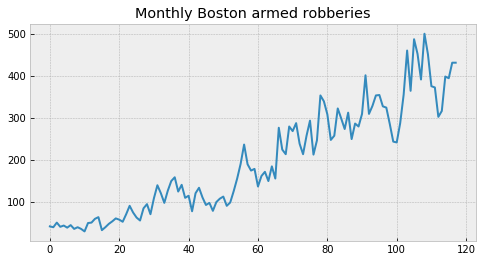

In [4]:
robb = pd.read_csv("../Временные ряды, общая теория/Series/monthly-boston-armed-robberies-j.csv")['Count']

with plt.style.context('bmh'):
    plt.figure(figsize=(8,4))
    plt.title('Monthly Boston armed robberies')
    plt.plot(robb);

Results of Dickey-Fuller Test:
Test Statistic                -7.601792e+00
p-value                        2.378602e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64


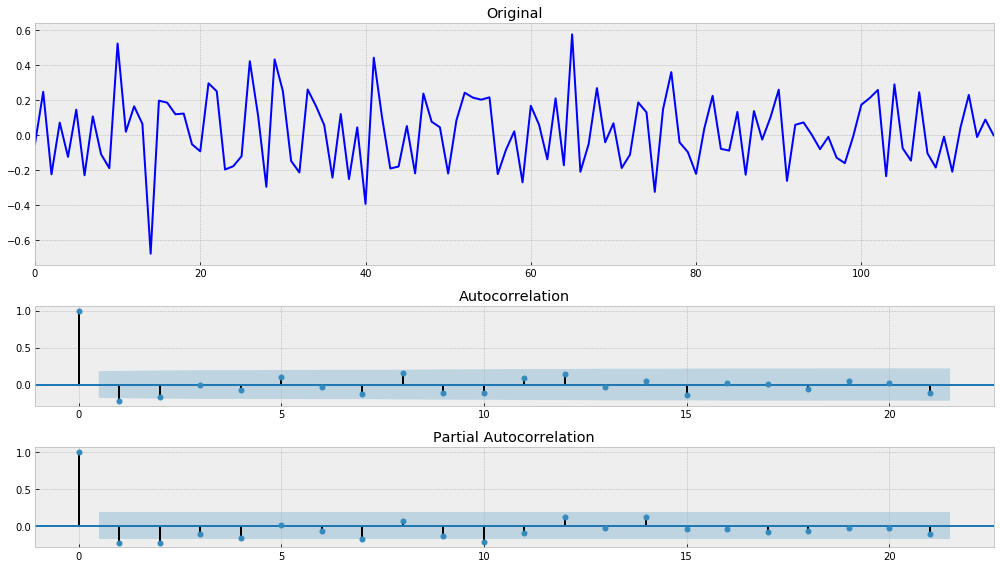

In [5]:
# Приведение ряда к стационарному виду
robb_boxcox = boxcox(robb,0)
robb_boxcox_diff = np.diff(robb_boxcox,1)
robb_stationary = robb_boxcox_diff
tsplot(robb_stationary)

### Скользящее среднее с параметром окна

In [6]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [7]:
def weighted_moving_average(series, n, weights):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    if not isinstance(weights, np.ndarray):
        weights = np.array(weghts)
    if len(weights) == n:
        return series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    else: return ('Error')

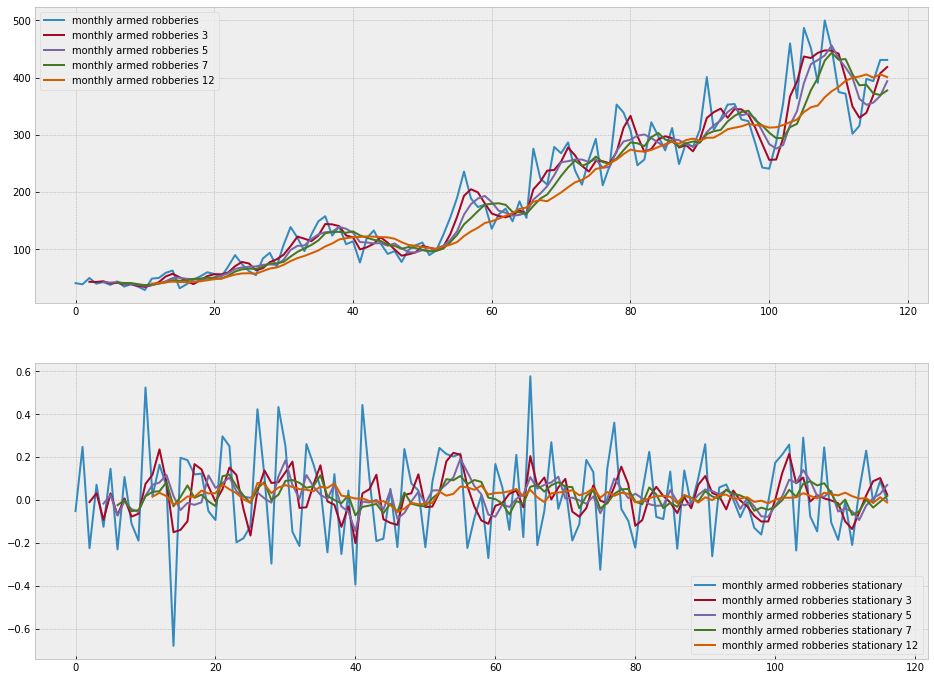

In [8]:
windows = [3, 5, 7, 12]

with plt.style.context('bmh'):
    plt.figure(figsize=(16,12))
    
    plt.subplot(2,1,1)
    plt.plot(robb, label='monthly armed robberies')
    for i in range(len(windows)):
        plt.plot(moving_average(robb,windows[i]), label='monthly armed robberies {}'.format(windows[i]))
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.plot(robb_stationary, label='monthly armed robberies stationary')
    for i in range(len(windows)):
        plt.plot(moving_average(robb_stationary,windows[i]), label='monthly armed robberies stationary {}'.format(windows[i]))
    plt.legend();


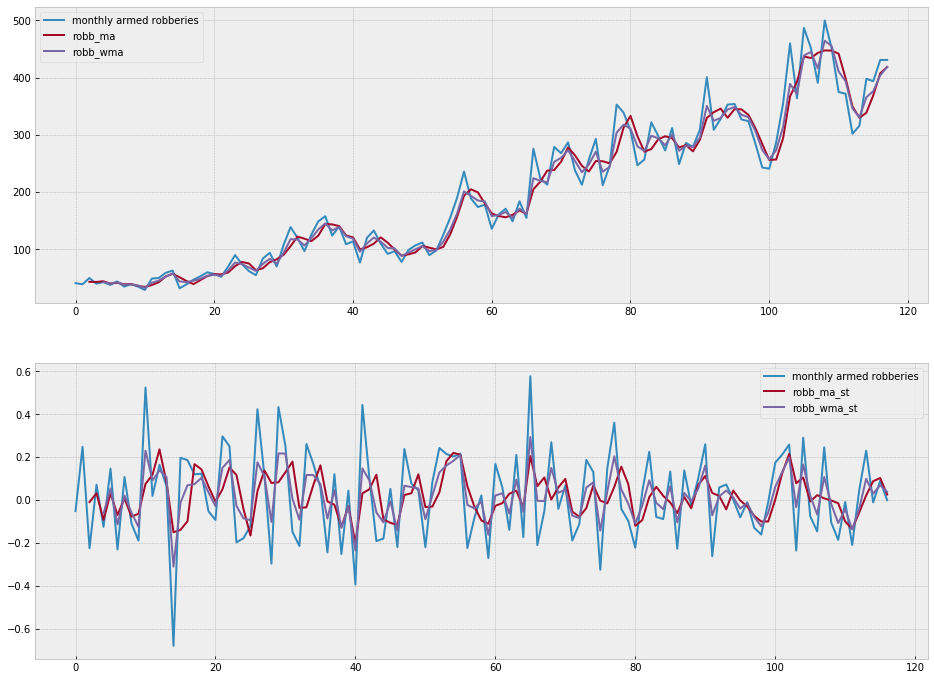

In [9]:
wma = weighted_moving_average(robb, 5, [1,2,3,5,13])
ma = moving_average(robb, 3)
wma_st = weighted_moving_average(robb_stationary, 5, [1,2,3,5,13])
ma_st = moving_average(robb_stationary, 3)

with plt.style.context('bmh'):
    plt.figure(figsize=(16,12))
    
    plt.subplot(2,1,1)
    plt.plot(robb, label='monthly armed robberies')
    plt.plot(ma, label='robb_ma')
    plt.plot(wma, label='robb_wma')
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.plot(robb_stationary, label='monthly armed robberies')
    plt.plot(ma_st, label='robb_ma_st')
    plt.plot(wma_st, label='robb_wma_st')
    plt.legend();

### Двойное экспоненциальное сглаживание

In [10]:
def double_ema(series, alpha, beta):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

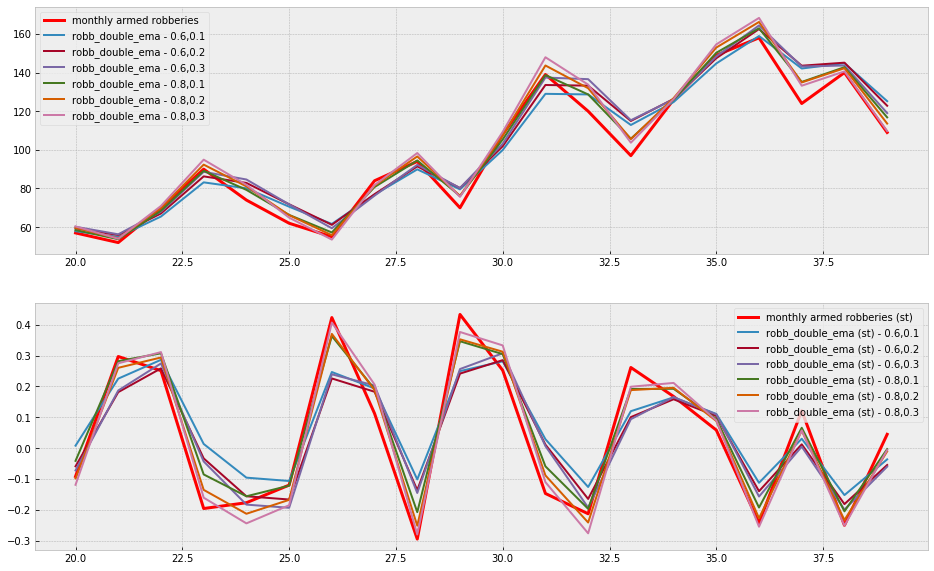

In [11]:
alpha = [0.6,0.8]
beta = [0.1,0.2,0.3]

with plt.style.context('bmh'):
    plt.figure(figsize=(16,10))
    
    plt.subplot(2,1,1)
    plt.plot(robb[20:40], linewidth=3, label='monthly armed robberies', color='red')
    for a in alpha:
        for b in beta:
            plt.plot(double_ema(robb,a,b)[20:40], label='robb_double_ema - {},{}'.format(a,b))
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.plot(pd.Series(robb_stationary)[20:40], linewidth=3, label='monthly armed robberies (st)', color='red')
    for a in alpha:
        for b in beta:
            plt.plot(double_ema(robb_stationary,a,b)[20:40], label='robb_double_ema (st) - {},{}'.format(a,b))
    plt.legend();

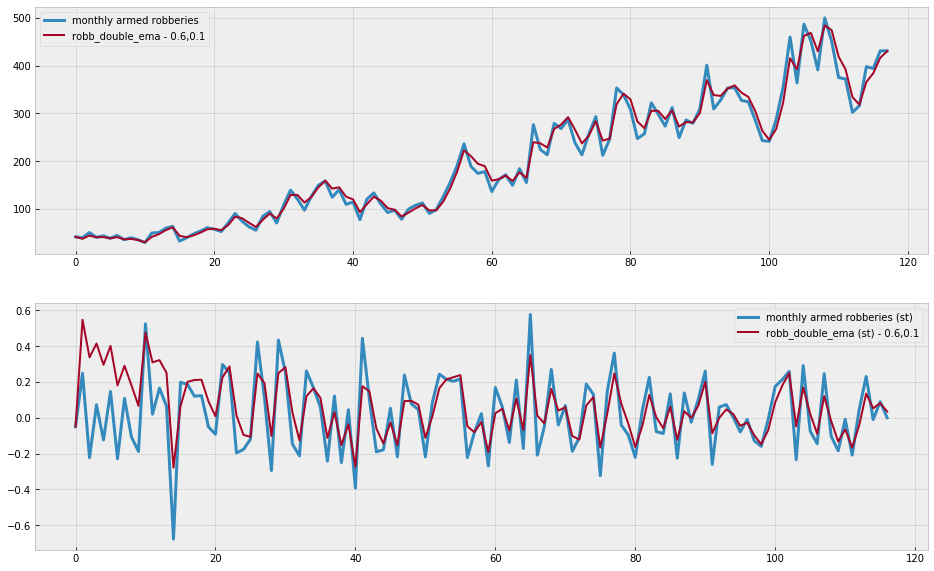

In [12]:
a = 0.6
b = 0.1

with plt.style.context('bmh'):
    plt.figure(figsize=(16,10))
    
    plt.subplot(2,1,1)
    plt.plot(robb, linewidth=3, label='monthly armed robberies')
    plt.plot(double_ema(robb,a,b), label='robb_double_ema - {},{}'.format(a,b))
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.plot(pd.Series(robb_stationary), linewidth=3, label='monthly armed robberies (st)')
    plt.plot(double_ema(robb_stationary,a,b), label='robb_double_ema (st) - {},{}'.format(a,b))
    plt.legend();

### Метод Хольта-Винтерса

In [13]:
# функция тренда
def initial_trend(series, season_len):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

# функция сезонности
def initial_seasonal_components(series, slen):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

# тройное экспоненциальное сглаживание (сезонность, уровень ряда, тренд)
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

# визуализация
def plot_tema(alpha, beta, gamma, ser, ser_to_plot, n_preds):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

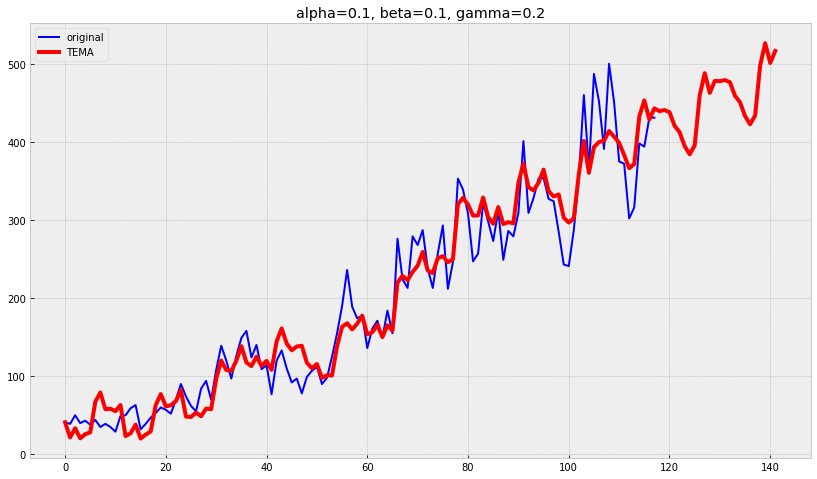

In [14]:
plot_tema(0.1, 0.1, 0.2, robb, robb, 24)

In [15]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

train_, test_, val_ = robb[:60], robb[60:70], robb[70:]
train_st, test_st, val_st = robb_stationary[:60], robb_stationary[60:70], robb_stationary[70:]

# подбор параметра
def mse_(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train_, 12, alpha, beta, gamma, 24)
    predictions = result[-len(test_):]
    error = mean_squared_error(predictions, test_)
    return error

def mse_st(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train_st, 12, alpha, beta, gamma, 24)
    predictions = result[-len(test_st):]
    error = mean_squared_error(predictions, test_st)
    return error

opt = minimize(mse_, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))
opt_st = minimize(mse_st, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [16]:
alpha_opt, beta_opt, gamma_opt = opt.x
alpha_opt_st, beta_opt_st, gamma_opt_st = opt_st.x
print(opt)
print('-'*70)
print(opt_st)

      fun: 1364.9258037208322
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.95585778e-04,  0.00000000e+00, -2.55347459e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 100
      nit: 23
   status: 0
  success: True
        x: array([0.95153365, 0.13678891, 1.        ])
----------------------------------------------------------------------
      fun: 0.056059057532830504
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.91906948e-04, -4.14390744e-05, -3.03784775e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 256
      nit: 42
   status: 0
  success: True
        x: array([0.00280556, 1.        , 0.00465279])


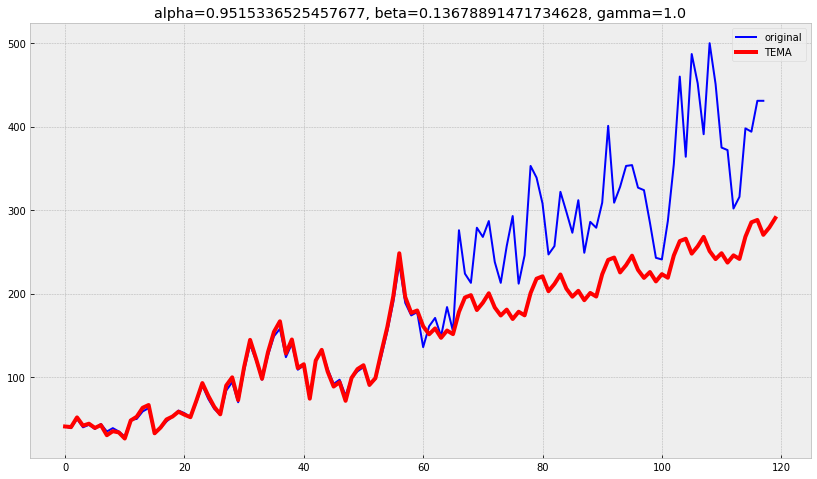

In [17]:
plot_tema(alpha_opt, beta_opt, gamma_opt, train_, robb, len(train_))

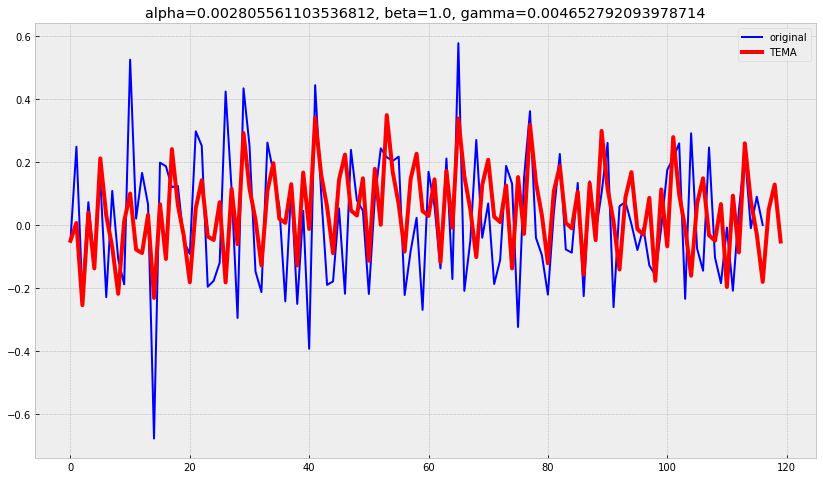

In [18]:
plot_tema(alpha_opt_st, beta_opt_st, gamma_opt_st, train_st, robb_stationary, len(train_st))

### Вывод
Стационарный ряд, исключающий информацию о тренде обрабатывается гораздо лучше
Стационарный ряд имеет очень частые колебания, которые хорошо воспринимаются методом Хольта-Винтерса.
Таким образом, из всех использованных моделей данный временной ряд лучше всего апроксимируется в стационарном виде методом Хольта-Винтерса.